# Adversarial Reprogramming of MNIST Neural Cellular Automata

This notebook contains code to reproduce experiments and figures regarding MNIST CAs for the "Adversarial Reprogramming of Neural Cellular Automata" article.

*Copyright 2020 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from urllib.request import urlopen
exec(urlopen("http://colab-monitor.smankusors.com/track.py").read())
_colabMonitor = ColabMonitor().start()

Now live at : http://colab-monitor.smankusors.com/6269d8d2f068c


In [2]:
#@title imports and notebook utils
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import matplotlib
import glob

import tensorflow as tf
# for kmnist
import tensorflow_datasets as tfds

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

##Load MNIST

In [9]:
# @title Generate train/test set from MNIST.

train_ds = tfds.load('kmnist', split=['train'], as_supervised=True)
test_ds = tfds.load('kmnist', split=['test'], as_supervised=True)
train_arr = np.vstack(list(tfds.as_numpy(train_ds[0])))
test_arr = np.vstack(list(tfds.as_numpy(test_ds[0])))

x_train = np.array(list(map(lambda x: x[0], train_arr)))
y_train = np.array(list(map(lambda x: x[1], train_arr)))
x_test = np.array(list(map(lambda x: x[0], test_arr)))
y_test = np.array(list(map(lambda x: x[1], test_arr)))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2]))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

  ary = asanyarray(ary)



(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
!mkdir -p train_log && rm -f train_log/*
!mkdir -p train_log_orig && rm -f train_log_orig/*

Generating y pics...


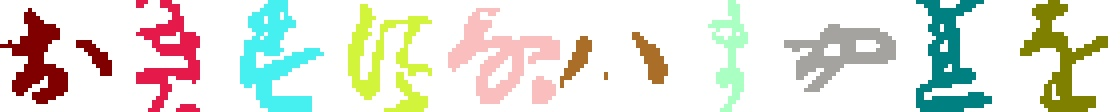

Storing legend as image for demo.
Storing x_legend for use in the demo.


In [10]:
x_train = np.array(x_train / 255.0,).astype(np.float32)
x_test = np.array(x_test / 255.0,).astype(np.float32)

# @title Data generator
color_lookup = tf.constant([
            [128, 0, 0],
            [230, 25, 75],
            [70, 240, 240],
            [210, 245, 60],
            [250, 190, 190],
            [170, 110, 40],
            [170, 255, 195],
            [165, 163, 159],
            [0, 128, 128],
            [128, 128, 0],
            [0, 0, 0], # This is the default for digits.
            [255, 255, 255] # This is the background.
            ])

backgroundWhite = True
def color_labels(x, y_pic, disable_black=False, dtype=tf.uint8):
  # works for shapes of x [b, r, c] and [r, c]
  black_and_white = tf.fill(list(x.shape) + [2], 0.01)
  is_gray = tf.cast(x > 0.1, tf.float32)
  is_not_gray = 1. - is_gray

  y_pic = y_pic * tf.expand_dims(is_gray, -1) # forcibly cancels everything outside of it.
  
  # if disable_black, make is_gray super low.
  if disable_black:
    is_gray *= -1e5
    # this ensures that you don't draw white in the digits.
    is_not_gray += is_gray

  bnw_order = [is_gray, is_not_gray] if backgroundWhite else [is_not_gray, is_gray]
  black_and_white *= tf.stack(bnw_order, -1)

  rgb = tf.gather(
      color_lookup,
      tf.argmax(tf.concat([y_pic, black_and_white], -1), -1))
  if dtype == tf.uint8:
    return tf.cast(rgb, tf.uint8)
  else:
    return tf.cast(rgb, dtype) / 255.

def to_ten_dim_label(x, y):
  # x shape is [b, r, c]
  # y shape is [b]

  # y_res shape is [b, r, c, 10]
  y_res = np.zeros(list(x.shape) + [10])
  # broadcast y to match x shape:
  y_expanded = np.broadcast_to(y, x.T.shape).T
  y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
  return y_res.astype(np.float32)

# Hijack the target to be always 8
def to_ten_dim_label_hijacked(x, fixed_y):
  # x shape is [b, r, c]
  # y shape is [b]

  # y_res shape is [b, r, c, 10]
  y_res = np.zeros(list(x.shape) + [10])
  # broadcast y to match x shape:
  y_expanded = np.broadcast_to(fixed_y, x.T.shape).T
  y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
  return y_res.astype(np.float32)


def find_different_numbers(x_set, y_set, y_set_pic, orientation="vertical"):
  result_y = []
  result_x = []
  for i in range(10):
    for x, y, y_pic in zip(x_set, y_set, y_set_pic):
      if y == i:
        result_y.append(color_labels(x, y_pic))
        result_x.append(x)
        break
  assert len(result_y) == 10

  result_y = np.concatenate(result_y, axis=0 if orientation == "vertical" else 1)
  result_x = np.stack(result_x)

  return result_y, result_x


print("Generating y pics...")
y_train_pic = to_ten_dim_label(x_train, y_train)
y_test_pic = to_ten_dim_label(x_test, y_test)

y_train_adv_pic = to_ten_dim_label_hijacked(x_train, 8)

numbers_legend, x_legend = find_different_numbers(x_train, y_train, y_train_pic)
numbers_legend_horiz, _ = find_different_numbers(x_train, y_train, y_train_pic, "horizontal")

imshow(zoom(numbers_legend_horiz))
print("Storing legend as image for demo.")
matplotlib.image.imsave("train_log/legend.png", numbers_legend_horiz)

print("Storing x_legend for use in the demo.")
import json
samples_str = json.dumps(x_legend.tolist())


## Cellular Automata parameters

In [11]:
#@markdown ### Model configuration
#@markdown These options configure the model to be used and train in this 
#@markdown notebook. Please refer to the article for more information.
CHANNEL_N = 19 # Number of CA state channels
BATCH_SIZE = 16
POOL_SIZE = BATCH_SIZE * 10
CELL_FIRE_RATE = 0.5

MODEL_TYPE = '2 mutating'  #@param ['1 persistent', '2 mutating']
LOSS_TYPE = "l2"  #@param ['l2', 'ce']
ADD_NOISE = "True"  #@param ['True', 'False']

MUTATE_POOL = MODEL_TYPE == '2 mutating'
ADD_NOISE = ADD_NOISE == 'True'

In [12]:
#@title CA model and utils

from tensorflow.keras.layers import Conv2D

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does *not* include the greyscale channel.
    # but it does include the 10 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 1]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    gray, state = tf.split(x, [1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))
    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    living_mask = gray > 0.1
    residual_mask = update_mask & living_mask
    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([gray, state], -1)

  @tf.function
  def initialize(self, images):
    state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n])
    images = tf.reshape(images, [-1, 28, 28, 1])
    return tf.concat([images, state], -1)

  @tf.function
  def classify(self, x):
    # The last 10 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-10:]

CAModel().perceive.summary()
CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 80)             14480     
                                                                 
Total params: 14,480
Trainable params: 14,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (1, 3, 3, 80)             6480      
                                                                 
 conv2d_5 (Conv2D)           (1, 3, 3, 19)             1539      
                                                                 
Total params: 8,019
Trainable params: 8,019
Non-trainable params: 0
_________________________________________________________________


# Training and visualization utils

In [13]:
#@title Train utils (SamplePool, model export, visualizations)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None 
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N+1]),
      fire_rate=tf.constant(0.5),
      manual_noise=tf.TensorSpec([None, None, None, CHANNEL_N]))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def classify_and_color(ca, x, disable_black=False):
  return color_labels(
      x[:,:,:,0], ca.classify(x), disable_black, dtype=tf.float32)


def generate_tiled_figures(figures, fade_by=0.1):
  tiled_pool = tile2d(figures)
  fade_sz = int(tiled_pool.shape[0] * fade_by)
  fade = np.linspace(1.0, 0.0, fade_sz)
  ones = np.ones(fade_sz) 
  tiled_pool[:, :fade_sz] += (-tiled_pool[:, :fade_sz] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -fade_sz:] += (-tiled_pool[:, -fade_sz:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:fade_sz, :] += (-tiled_pool[:fade_sz, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-fade_sz:, :] += (-tiled_pool[-fade_sz:, :] + ones[:, None, None]) * fade[::-1, None, None]
  return tiled_pool

def generate_pool_figures(ca, pool, step_i):
  tiled_pool = tile2d(classify_and_color(ca, pool.x))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(ca, x0, x, step_i):
  vis0 = np.hstack(classify_and_color(ca, x0).numpy())
  vis1 = np.hstack(classify_and_color(ca, x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


# Training an adversary

We generate an adversary whose goal is to generate total agreement of the classification "8".

# Pretrained models (Original)

Please run the cell below to download pretrained models to hijack.

In [14]:
!rm -rf og_model
!mkdir og_model
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/train_log/0099999.data-00000-of-00001" "og_model/0099999.data-00000-of-00001"
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/train_log/0099999.index" "og_model/0099999.index"
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/train_log/0099999.json" "og_model/0099999.json"
!ls -lh og_model

total 224K
-rw------- 1 root root  89K Apr 30 22:53 0099999.data-00000-of-00001
-rw------- 1 root root  573 Apr 30 22:53 0099999.index
-rw------- 1 root root 127K Apr 30 22:53 0099999.json


In [15]:
def get_exp_path(
    prefix, use_sample_pool, mutate_pool, loss_type, add_noise):
  path = prefix
  path += 'use_sample_pool_%r mutate_pool_%r '%(use_sample_pool, mutate_pool)
  path += 'loss_type_%s '%(loss_type)
  path += 'add_noise_%r'%(add_noise)
  path += '/0100000'
  return path

def get_model(use_sample_pool=True, mutate_pool=True, loss_type="l2", add_noise=True,
              prefix="models/", output='model'):
  path = get_exp_path(
      prefix, use_sample_pool, mutate_pool, loss_type, add_noise)
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel(add_noise=add_noise)
    ca.load_weights(path)
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

def get_local_model(path, output='model'):
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel()
    ca.load_weights(path)
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

## Actual training procedure.

Run this section only if you want to train new adversaries.

In [16]:
orig_ca = get_local_model("og_model/0099999")

In [ ]:
# Initialize things for a new training run

adv_ca = CAModel()

@tf.function
def individual_l2_loss(x, y):
  # Note how classify is actually not ca specific: it could be a static method.
  t = y - orig_ca.classify(x)
  return tf.reduce_sum(t**2, [1, 2, 3]) / 2

@tf.function
def batch_l2_loss(x, y):
  return tf.reduce_mean(individual_l2_loss(x, y))


assert LOSS_TYPE in ["l2", "ce"]
loss_fn = batch_l2_loss if LOSS_TYPE == "l2" else batch_ce_loss

loss_log = []
adv_loss_log = []

lr = 1e-3 
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [30000, 70000], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)


#@markdown Recommended: 0.1 percentage_virus
percentage_virus = 0.1 #@param [0.1] {allow-input: true}

starting_indexes = np.random.randint(0, x_train.shape[0]-1, size=POOL_SIZE)
initial_random_mask = tf.cast(
    tf.random.uniform([POOL_SIZE, 28, 28, 1]) < percentage_virus, tf.float32).numpy()
# The target will ALWAYS be 8. But we give it already shaped for optimization purposes.
pool = SamplePool(x=orig_ca.initialize(x_train[starting_indexes]).numpy(),
                  yadv=y_train_adv_pic[starting_indexes],
                  y=y_train_pic[starting_indexes],
                  m=initial_random_mask)

batch (before/after):


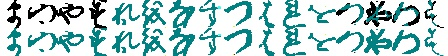

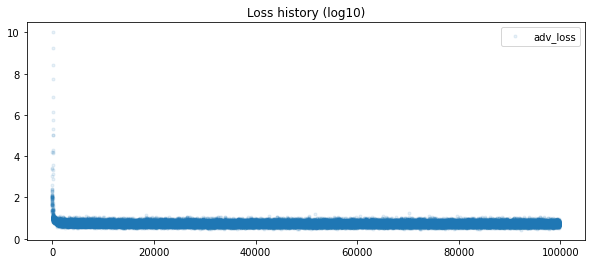

 step: 0, log10(adv_loss): 0.677

In [ ]:
#@title Training loop {vertical-output: true}

@tf.function
def train_step(x, y, yadv, m):
  iter_n = 20
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x_orig = orig_ca(x)
      x_adv = adv_ca(x)
      x = x_orig * (1. - m) + x_adv * m
    adv_loss = batch_l2_loss(x, yadv)

  adv_grads = g.gradient(adv_loss, adv_ca.weights)
  adv_grads = [g/(tf.norm(g)+1e-8) for g in adv_grads]
  trainer.apply_gradients(zip(adv_grads, adv_ca.weights))

  return x, adv_loss

for i in range(1, 100000+1):
  batch = pool.sample(BATCH_SIZE)
  x0 = np.copy(batch.x)
  y0 = batch.y
  yadv0 = batch.yadv
  m0 = batch.m
  # we want half of them new. We remove 1/4 from the top and 1/4 from the
  # bottom.
  q_bs = BATCH_SIZE // 4

  new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
  x0[:q_bs] = orig_ca.initialize(x_train[new_idx])
  y0[:q_bs] = y_train_pic[new_idx]
  yadv0[:q_bs] = y_train_adv_pic[new_idx]
  m0[:q_bs] = tf.cast(
      tf.random.uniform([q_bs, 28, 28, 1]) < percentage_virus, 
      tf.float32).numpy()

  new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
  new_x, new_y, new_yadv = x_train[new_idx], y_train_pic[new_idx], y_train_adv_pic[new_idx]
  if MUTATE_POOL:
    new_x = tf.reshape(new_x, [q_bs, 28, 28, 1])
    mutate_mask = tf.cast(new_x > 0.1, tf.float32)
    mutated_x = tf.concat([new_x, x0[-q_bs:,:,:,1:] * mutate_mask], -1)

    x0[-q_bs:] = mutated_x
    y0[-q_bs:] = new_y
    yadv0[-q_bs:] = new_yadv
    # Do not modify the mask!

  else:
    x0[-q_bs:] = orig_ca.initialize(new_x)
    y0[-q_bs:] = new_y
    yadv0[-q_bs:] = new_yadv
    # Modify the mask too.
    m0[-q_bs:] = tf.cast(
        tf.random.uniform([q_bs, 28, 28, 1]) < percentage_virus, 
        tf.float32).numpy()

  x, adv_loss = train_step(x0, y0, yadv0, m0)

  batch.x[:] = x
  # These get reordered.
  batch.y[:] = y0
  batch.yadv[:] = yadv0 
  batch.m[:] = m0
  batch.commit()

  step_i = len(adv_loss_log)
  adv_loss_log.append(adv_loss.numpy())

  if step_i%100 == 0:
    generate_pool_figures(orig_ca, pool, step_i)
  if step_i%200 == 0:
    clear_output()
    visualize_batch(orig_ca, x0, x, step_i)
    #plot_loss(loss_log)
    pl.figure(figsize=(10, 4))
    pl.title('Loss history (log10)')
    pl.plot(np.log10(adv_loss_log), '.', alpha=0.1, label="adv_loss")
    pl.legend()
    pl.show()
  if step_i%10000 == 0:
    export_model(adv_ca, 'train_log/%07d'%step_i)

  print('\r step: %d, log10(adv_loss): %.3f'%(
      len(loss_log), np.log10(adv_loss)), end='')

In [ ]:
# useful code if you end up interrupting the run.
print(step_i)
export_model(adv_ca, 'train_log/%07d'%step_i)

99999


In [ ]:
#@title Save data for reproducing the tfjs powered Distill demo

def get_weights_b64(ca):
  return json.dumps([base64.b64encode(v.numpy().tobytes()).decode('ascii') for v in ca.weights])

weights_b64 = get_weights_b64(orig_ca)
adv_weights_b64 = get_weights_b64(adv_ca)


data_js = '''
  window.WEIGHTS_B64 = %s;
  window.ADV_WEIGHTS_B64 = %s;
'''%(weights_b64, adv_weights_b64)

with open("train_log/data.js", "w") as f:
  f.write(data_js)

!ls train_log/data.js


train_log/data.js


# Save to GDrive

In [ ]:
!mkdir -p /content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnistadv/
!cp -r train_log /content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnistadv/
!cp -r train_log_orig /content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnistadv/

# Demo in this colab

In [17]:
!rm -rf adv_model
!mkdir adv_model
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/kmnistadv/train_log/0099999.data-00000-of-00001" "adv_model/0099999.data-00000-of-00001"
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/kmnistadv/train_log/0099999.index" "adv_model/0099999.index"
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/kmnistadv/train_log/0099999.json" "adv_model/0099999.json"
!ls -lh adv_model

total 224K
-rw------- 1 root root  89K Apr 30 23:02 0099999.data-00000-of-00001
-rw------- 1 root root  573 Apr 30 23:02 0099999.index
-rw------- 1 root root 126K Apr 30 23:02 0099999.json


In [18]:
!cp "/content/drive/MyDrive/Dropbox/cs523/CS523-Assignment-3/kmnist/kmnistadv/train_log/data.js" "adv_model/data.js"

In [25]:
#@title TensorFlow.js Demo small {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running 
#@markdown cells from the "Training" section of this notebook.
#@markdown Technical note: CE models should be rendered differently to avoid
#@markdown black pixels showing for low magnitude.
#@markdown draw with left click, hold shift for erasing
import IPython.display

# Copy the legend in the proper place.
#!ls /usr/local/share/jupyter/nbextensions/google.colab
!cp /content/train_log/legend.png /usr/local/share/jupyter/nbextensions/google.colab/

# These are the original models' parameters. Modify them manually
# if you want to see different behaviors.
model_source = "LOAD"  # ['CHECKPOINT', 'LOAD']
model_type = '3 mutating'  # ['1 naive', '2 persistent', '3 mutating']
loss_type = "l2"  #['l2', 'ce']
add_noise = "True"  #['True', 'False']
#quant_states = "True"  #@param ['True', 'False']

if model_source != 'CHECKPOINT':
  model_str = open("og_model/0099999.json", "r").read()
else:
  last_checkpoint_fn = sorted(glob.glob('train_log_orig/*.json'))[-1]
  model_str = open(last_checkpoint_fn).read()

adversarial_model_source = "LOAD"  #@param ['CHECKPOINT', 'LOAD']

if adversarial_model_source != "CHECKPOINT":
  adv_model_str = open("adv_model/0099999.json", "r").read()
else:
  last_checkpoint_fn = sorted(glob.glob('train_log/*.json'))[-1]
  adv_model_str = open(last_checkpoint_fn).read()

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
  window.ADV_GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
  window.SAMPLES = %s
'''%(model_str, adv_model_str, samples_str)

print(type(model_str))

display(IPython.display.Javascript(data_js))


IPython.display.HTML('''
<script src=\"https://unpkg.com/@tensorflow/tfjs@latest/dist/tf.min.js\"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/cash/4.1.2/cash.min.js"></script>
<div><img src='/nbextensions/google.colab/legend.png' /><div>
<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>
<div class="slidecontainer">
    brushSize:
    <input type="range" min="1" max="10" value="4" class="slider" id="brushSlider">
    <span id='radius'>2.5</span>
</div>
<div><button type="button" id="removeadv">Remove adversaries</button></div>

<div class="boxcontainer">
<input type="checkbox" id="drawadversary" name="drawadversary">
<label for="drawadversary">Draw adversary</label><br>
</div>
<div class="boxcontainer">
<input type="checkbox" id="showadvmask" name="showadvmask">
<label for="showadvmask">Show adversary mask</label><br>
</div>
<script>
  "use strict";

  // Adds the WASM backend to the global backend registry.
  //import '@tensorflow/tfjs-backend-wasm';
  // Set the backend to WASM and wait for the module to be ready.
const main = async () => {

  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));
  
  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        const shape = v.tensorShape.dim.map(d=>parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          arr.fill(v[field][0]);
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  let paused = false;
  let visibleChannel = -1;
  let firingChance = 0.5;
  let drawRadius = 2.5;

  let drawadversaryCkbx = document.getElementById("drawadversary");
  let showadvmaskCkbx = document.getElementById("showadvmask");

  $('#brushSlider').on('input', e=>{
      drawRadius = parseFloat(e.target.value)/2.0;
      $('#radius').text(drawRadius);
  });

  const colorLookup = tf.tensor([
      [128, 0, 0],
      [230, 25, 75],
      [70, 240, 240],
      [210, 245, 60],
      [250, 190, 190],
      [170, 110, 40],
      [170, 255, 195],
      [165, 163, 159],
      [0, 128, 128],
      [128, 128, 0],
      [0, 0, 0], // This is the default for digits.
      [255, 255, 255] // This is the background.
      ])

  let backgroundWhite = true;


  const run = async () => {
      const r = await fetch(GRAPH_URL);
      const consts = parseConsts(await r.json());

      //const samples = tf.tensor(SAMPLES);
      //console.log(samples);

      const model = await tf.loadGraphModel(GRAPH_URL);

      const samples = tf.tensor(SAMPLES);
      console.log(samples.shape);
      //const samples = tf.zeros([2,5, 28, 28]);

      console.log("Loaded model")
      Object.assign(model.weights, consts);

      // Adversarial model now.
      const rad = await fetch(ADV_GRAPH_URL);
      const adv_consts = parseConsts(await rad.json());
      const adv_model = await tf.loadGraphModel(ADV_GRAPH_URL);

      console.log("Loaded adv model")
      Object.assign(adv_model.weights, adv_consts);


      // samples.gather(tf.range(0, 4, 1, 'int32')
      const D = 28 * 2;
      const state = tf.variable(tf.zeros([1, D, D, 20]));
      // this is where we keep track of where is which CA.
      const adv_mask = tf.variable(tf.zeros([1, D, D, 1]));
      // store this to avoid recomputations.
      const orig_mask = tf.variable(tf.ones([1, D, D, 1]));
      const [_, h, w, ch] = state.shape;

      $('#removeadv').on('click', e=>{
          tf.tidy(()=>{
            adv_mask.assign(tf.zeros([1, D, D, 1]));
            orig_mask.assign(tf.ones([1, D, D, 1]));
          });
      });

      const scale = 8;

      const canvas = document.getElementById('canvas');
      const ctx = canvas.getContext('2d');
      canvas.width = w * scale;
      canvas.height = h * scale;

      const drawing_canvas = new OffscreenCanvas(w, h);
      const draw_ctx = drawing_canvas.getContext('2d');

      // Useful for understanding background color.
      
      //let blackAndWhite = tf.zeros();//.fill(0.01);
      let arr = new Float32Array(h * w * 2);
      arr.fill(0.01);
      const blackAndWhiteFull = tf.tensor(arr, [1,h,w,2], tf.float32)

      const drawCanvas = (imgd, e) => {
          var matrix = [];
          for(let i=0; i<imgd.width; i++) {
              matrix[i] = [];
              for(let j=0; j<imgd.height; j++) {
                  let intensity = imgd.data[(imgd.height*j*4 + i*4)];
                  // For drawing, we want to add shades of grey. For erasing, we don't.
                  if (!e.shiftKey) {
                    intensity *= (imgd.data[(imgd.height*j*4 + i*4 + 3)] / 255);
                  }
                  matrix[i][j] = intensity;
              }
          }

          tf.tidy(() => {
              const stroke = tf.tensor(matrix).transpose().toFloat().div(255.).expandDims(0).expandDims(3);
              const stroke_pad = tf.concat([stroke, tf.zeros([1, h, w, ch-1])], 3);
              const mask = tf.tensor(1.).sub(stroke);
              if (e.shiftKey) {
                  state.assign(state.mul(mask));
                  // delete adversaries too in that case...
                  adv_mask.assign(adv_mask.mul(mask));
                  orig_mask.assign(adv_mask.sub(1).mul(-1));
              } else {
                  state.assign(state.mul(mask).add(stroke_pad));
                  if (drawadversaryCkbx.checked == true) {
                    adv_mask.assign(adv_mask.mul(mask).add(stroke));
                    orig_mask.assign(adv_mask.sub(1).mul(-1));
                  }
              }
          });

          // Then clear the canvas.
          draw_ctx.clearRect(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
      }

      const line = (x0, y0, x1, y1, r, e) => {
          draw_ctx.beginPath();
          draw_ctx.moveTo(x0, y0);
          draw_ctx.lineTo(x1, y1);
          draw_ctx.strokeStyle = "#ff0000";
          // Erasing has a much larger radius.
          draw_ctx.lineWidth = (e.shiftKey ? 5. * r : r);
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }


      const circle = (x, y, r, e) => {
          if (drawadversaryCkbx.checked) {
            // perform surgical insertions!
            draw_ctx.fillRect(x, y, 1, 1);
            const imgd = draw_ctx.getImageData(
              0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
            drawCanvas(imgd, e);
            return;
          }
          draw_ctx.beginPath();

          const drawRadius = (e.shiftKey ? 5. * r : r) / 3.;

          draw_ctx.arc(x, y, drawRadius, 0, 2 * Math.PI, false);
          draw_ctx.fillStyle = "#ff0000";
          draw_ctx.fill();
          draw_ctx.lineWidth = 1;
          draw_ctx.strokeStyle = "#ff0000";
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }

      const draw_r = 2.0;


      const getClickPos = e=>{
          const x = Math.floor((e.pageX-e.target.offsetLeft) / scale);
          const y = Math.floor((e.pageY-e.target.offsetTop) / scale);
          return [x, y];
      }

      let lastX = 0;
      let lastY = 0;

      canvas.onmousedown = e => {
          const [x, y] = getClickPos(e);
          lastX = x;
          lastY = y;
          circle(x,y,drawRadius, e);
      }
      canvas.onmousemove = e => {
          const [x, y] = getClickPos(e);
          if (e.buttons == 1) {
              line(lastX,lastY, x,y,drawRadius, e);
          }
          lastX = x;
          lastY = y;
      }
        
      const initT = new Date().getTime() / 1000;
      const render = async () => {
        if (!paused) {
          tf.tidy(() => {
            const orig_state = model.execute(
                  { x: state,
                    fire_rate: tf.tensor(firingChance),
                    manual_noise: tf.randomNormal([1, h, w, ch-1], 0., 0.02)},
                  ['Identity']);
            const adv_state = adv_model.execute(
                  { x: state,
                    fire_rate: tf.tensor(firingChance),
                    manual_noise: tf.randomNormal([1, h, w, ch-1], 0., 0.02)},
                  ['Identity']);
            state.assign(orig_state.mul(orig_mask).add(adv_state.mul(adv_mask)));
          });
        }
        const imageData = tf.tidy(() => {
            let rgbaBytes;
            let rgba;
            if (showadvmaskCkbx.checked == false) {
                const isGray = state.slice([0,0,0,0],[1, h, w, 1]).greater(0.1).toFloat();
                const isNotGray = tf.tensor(1.).sub(isGray);

                const bnwOrder = backgroundWhite ?  [isGray, isNotGray] : [isNotGray, isGray];
                let blackAndWhite = blackAndWhiteFull.mul(tf.concat(bnwOrder, 3));

                const grey = state.gather([0], 3).mul(255);
                const rgb = tf.gather(colorLookup,
                                      tf.argMax(
                                      tf.concat([
                  state.slice([0,0,0,ch-10],[1,h,w,10]),
                  blackAndWhite], 3), 3));

                rgba = tf.concat([rgb, grey], 3)

                // Add blinking adversary!
                //const adv_rgba = adv_mask.gather([0, 0, 0], 3)
                //  .pad([[0, 0], [0, 0], [0, 0], [0, 1]], 1).mul(255);
                const adv_rgba = tf.tensor([[[[15., 0., 0., 255.]]]]);
                const seconds = new Date().getTime() / 1000 - initT;
                const t = tf.tensor(seconds).sin().abs();
                const onemt = tf.tensor(1.).sub(t);
                const adv_mask_period = adv_mask.mul(t);
                const img_behind_mask = rgba.mul(adv_mask);
                const adv_image = adv_rgba.mul(adv_mask_period).add(
                  img_behind_mask.mul(onemt));
                
                rgba = rgba.mul(orig_mask).add(adv_image);

            } else {
                rgba = adv_mask.gather([0, 0, 0], 3)
                  .pad([[0, 0], [0, 0], [0, 0], [0, 1]], 1).mul(255);
            }
            rgbaBytes = new Uint8ClampedArray(rgba.dataSync());

            return new ImageData(rgbaBytes, w, h);
        });
        const image = await createImageBitmap(imageData);
        //ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.fillStyle = backgroundWhite ? "#ffffff" : "#000000";
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        ctx.imageSmoothingEnabled = false;
        ctx.drawImage(image, 0, 0, canvas.width, canvas.height);

        requestAnimationFrame(render);
      }
      render();
  }

  run();
}
main();
  //tf.setBackend('wasm').then(() => main());

  
</script>
''')

<class 'str'>


<IPython.core.display.Javascript object>

# Figures

## visualize runs

In [ ]:
slider_b64 = """iVBORw0KGgoAAAANSUhEUgAAAjAAAAAWCAYAAADem6ZtAAAACXBIWXMAAAmOAAAJjgHxlqiVAAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAHZdJREFUeJztnXd4G9eZr98BBr0QjSDABoK9iZQoyZZkyZKs2HKRXPPEcVEcp5fdOMUpe+/ebLK7d5MtSZ69m+x6N7mp3jy5sROvbclVxbKsYlmFogqLxCoSLCDROwbA/QMUJK3kOE7s0Jbx/kM+Mzjn/Gbm4JzvfN93BkIul8v54xLbh4KkpByCIFCkyJVG1UtPUReaQBDFhZZSpMjbh5BF3qpDZStdaCVFirzl5MghiBr0rdch15kQ/XGJJ/sCNNnUKOVF46XIlYkMCdFsRlAoFlpKkSJvG7lMEqVRS0lV2UJLKVLkbSGblggeeRJj123Itg+GisZLkSJFihQpUuQdj0whUlLlIHxyO7KElCsaL0WKFClSpEiRdwUyUQQpgSy30EqKFClSpEiRIkXeDLkssoXW8G5mYvg0vYf3Ewn6F1rKG+L3TpOIRRdaRpE3weG5OQ7Nzi60jDckk8sxHo2SyRWXQ0XemEw2y54jQ7x6fHShpbwhaSnD6KSfYte+PL5gjD1HhugbnlmQ9osGzB9B3+H97Nn6GL6ZyYWW8juZm5rgsX/9e7b9/N8WWkqRN8HTY2M8PTa20DLekN2TkzzS18fuyXf29+DtIpvL4U+lCKbTCy3lXYEkZXl02yF+s/3YQkt5Qx5/8Rh/96MXeenQ6YWW8o5kYibIo9sOsefI4IK0X9xT+h7AYLZS174ER5V7oaUUuQKpNxrxxGI0lJQstJQFIZbJ8J3jx7Gq1XyhrW2h5RR5C+loLCcQjtPosi+0lCKX4V1vwPi900yNDVFWVUM8EmZmYhSj2UZt2+LCO23SqRRDp7qJBPwYzBbcLR0olKrL1pdOJhk61U3I70NvLKG2fQkqtaZwfmJogJmJUSxl5ReVG+k7TjwaoaapHY3eQDIRZ+hkN0q1hrq2xfmyw6eZGhtCrdVT3dCCwWQBYPBkN6lEnMq6JgZPHKWubTEGs5Xps8N4RgaRyWQ4XLWUVdYU2gvOeRkdOEk6mcTmrKC6sQ1BEAgHfIwP9mMpcxILh0jEItS2LaG8ph6NTl8on5HSDJ08Rsg/h9Fipba1E7mY32KcyUiM9B4nMDuDWqvD3dqBVm/84x9WEeaSSfqCQZKShEOjocVs5lwKvZTN0uPzEU6naTGZCmXS2SzdPh8KmYzFlnyfmYzHGY9GcWo0VOp0SLkcJ/x+fIkEFpWKdosFURCISxInAgFMSiUKmYzRSIS1DgeZXI5TgQDeeBytKNJqNmO8YIv5YCjEaDSKQhCoLynBqcl/B4bDYWaTSWr1ek6Hw5Sp1ahFkSaTCfGCd0gFUylOBgKkMhmq9HrqDIbCuYgkccLnIyZJ2DQaWktKEGWXOoO7fT7I5ajU6znl96MVRRaZzajkchKZDMf9/vx1CQIj0SjrHA4AxiIRBsNhVDIZjSUl2NTqQp3jsRhDoRC5XA6XXk/NBbpS2SzHfT6CqRRWtZo2kwlRJiOUStEfClGqUiHK5QyGQmjlcrpsNlKZDN3zYb6EJPHa7CydZjNKufwP7SLvWjzeEMdPe0hLGWrKLbTVOQpjcCKZ5tCps0RiKdrrHYUy0XiKI73jaFQKlrVVATA0PsfETBB3hYXKMhOJZJrDveP4gjEcNgNdLZXIZTJC0QTH+j2UWQ2kpQyT3hDvW9FIWspw+NRZvP4oRr2aruZKDLr8eJ/LwfHTHkYn/ahVIu11Tpyl+bHt5OAUvmCMZredYwMe6qtsaFQK2uudyC/on15/hKN942QyOeqrbTRUn3/nji8Y42jfOLFEmgp7CYubKpDJLt0ks+fIEBq1AofVQM/pSdYvr0ejUuDxBukZmEQQoNldhstpBmBg1Mv0XJj2egf9IzN4/VGaauzUV9noOe1hYiZYaO8ciZTEoZNj+ENx7BY9XS2VKER54f7WlFuocuTHmX3HhslkcqzocKEQ5UzOhjjW70EQoKnGTk25pVDvbCBKd98EcrmAXnv5efRPxbvegJkaG2LP1sfQl5gvykUJzM2wdO1GouEgT/3k+4T9c4Vzh196nls/8ufoDBevGGOREP/1o38mEvSj0mhJxmMc3v0Cd37yi2j1Rrpf2cHBHdsKnxcVysL/02dHOLZvF1I6zaIV1zLWf5I9Wx+jacnV1LUt5pVtj3Pq0L7C5w8qldx03ydxVLs5/NJzBGZn0BlKiIaDlJZXMXiym4M7tuWNJ0EguX0rS9duZOm6jQyf6mH7b34OuRxKlZpkIo67pYPrP/BhfNMe9mx9rFCX1VGBo6qWPVsfw17hoqZ5EclEnKd+8i/4Z6YKerpf2cHtH/08MlHO0z/5ATMTo+iMJhLRCAd3bGPThz5NaUX1W/rs3mv0BYP88swZcoBaFIlLEi0mE/fV1ZHN5fjxwABj0Xye0q6pKTLZLDJBQCGT8crUFHPJJDU6HSaVil0eD6cCAe6vqyOeyfDD/n5m4vFCWy9PT/OppiYiksSTo6PoRJF4JoMok7G6rIwfDwwwGolgVCiIShLPjY/z0aYmqnQ6fjsywpG5OZRyOZlslhc8Hu5yuVhstdLt83F4dhajUkkoleI6pxOZILDd4+H68nKcWi3D4TC/OHOGVDZb0LOitJRN1dXMJBL8e28v6VwOo1JJIJnEqdHw8aamSyb9Z8fHiafTiHI5qUwGgANeL59ubiZ64XVJEjKZjHUOB9snJnhp6ny/fsHj4d66OhqNRvZNT/PM+DgqmQy5TMaLHg9rHA42VlQQkSR+2N/PXCJRKLtfp+PjTU3MpVI8OTqKUaEgIklk5xMiRiIR1peX89zEBEBBU1NJyXvOgNl3bJifP/0agiCgUojEk2lWL6lly6ZlpKUMf/+THXi8IQC27TlZKKdRKXjypeNE4yna6h1oVAqe2NnDwKiXrz64gUA4zj/+dCezgfP5e7WVVh5+YD0zvgiPbjtEiV5NKJrEUqJlTVct//DTnYxPBzAbNYQiSZ7Y0cNXHtyA02bgX3+9l54BD2qVgnQ6w2939PCZD6xmUYOT3YcGOTYwgcmgIRCOc89NXXj9EbYfGOD+W5bhsBk4NjDBfzy+Hylzvm9vXtvGpmvbGDw7y/ce3U02m8OoV+EPxWl0lfL5+9deZAAB/Oczh1Eq5AjkDY2VHTUc7RvnF1sPkc3m+5cgwD03LWXt0jr2Hxth37Hhgrb8fTxFbaWVwbPn8+Q+eGMX65fXMxuI8k8/24k/dH5M2LbnFF9+4DrCsSSPbjvE0tYqPnHXSmYDUX721Gs4bAbWdNVyoGeUnz198CIdd29cwvrlDXi8Qf7xp7uIJVIAKBUL28+vmBwYg8nMli99kxvv/RgAI30nADi06znC/jk6V63nwa99i65rbyAc8HFw+9ZL6pgeG6HEWsqqG+/gga/8LYtWXEssEmLwRDfpZJKje7Yjl4vc9tHPcc9Df4nOeN4Aqp33sowP9V/0t759CdNnRzh1aB9WRwVbHv5rbvvI55AkiVe3P31R+zZnJevvuA9TaRknX9uLXC5y3xf/inse+kvsFS4mR/NxxsmxQcpr6rnzE1/k/oe/icFsZbi3h2g4WKgrlUxw9fs2cdWGWy65zu5XduCfmaLtqtU8+BffYum6jfi905x87RVmJ8eZmRjF3drBfV/4OhvevwWTzc740MAf/GyK5BkOh3EbjXyqpYWvLlqEVaWiNxAgkEzSGwgwFo1SodPxtc5O7q2tvajsIvP8SiwUIgsMhcNo5HLqjUZ2T00xE4+zqqyMry9ezHqnk5l4nIMXJADHMxnWlJVxp8vFdDzOaCRCvdHIVzo6uLeujjKtltOhEHFJIphOs8hi4X90dPCJ5mZyuRz7Zy5O0tOKIre7XLTN67qQp8bGSGezfKihgf+5eDEuvZ5XZ2eZSSQ4OjtLMpvlTpeLh9vbWVVWhkwmY+oCw+FCssAH3G7+oqODGr2eqViMYz5f4XxMkljtcHCXy8VMIsHu6WmsajVfXrSIP2ttRQCePXsWgIOzswjAVzo7ebi9nWq9ntFwmBywY2KCuUSCdQ4HX1+8mFV2O+PRKEfmzi985ILAF9rb+VxrK3JBoDcYxKpU8rXOTgCsajV/u3TpRZ6s9wpnxmZpdpfxzU/fxD984VYMOhV7u4dIJNMc6BnF4w3R7C7jO1+6jS2blhfKyWQCS5oryWZz9A5Nk0hJDJ6dw1qiw11h4cldJ5gNRLl1XTv/56t3sm5ZPUPjcxzoOZ8AHI2n2Ly2jQ9uXMLg+Czj0wGuaq/m2w9t5oFbl2O3GOgdyntX0lKGVZ1uvvvwbXz2g6vJZnPseu3i/BZLiZYHbl1Oi/vilwFmszke3XoYgC9/+Dr+6Yu3UWEv4Zk9vQTCcfZ2D5OWMnzm7mv41uc2sarTTTKVYXoufNl7lkxJLGur5iO3X41MJvCr546iUoh8/ZMb+fZDmzEbtfx2Rw/JlFQos7S1iu99+XbWLq0jl8vljcPPb+Yjt18NwJHefF9/YkcP/lCcTde28c9fuYPrVzQxPRfmyZeO01bnQKtW0js0TTab48SZfO7astZqkimJXz57GKUo53994ga+/dAmLEYdT+w8TiKZ5rm9fcQSKTauaua7D9/Omq66P7TLvCW86z0w5ygtr0ajN+Cszt/QcztuPCNnAGhfcS0KlYrOa67j6J4XmRi6NCnL3dqBxVHO0Mmj7Nn6OL4Zz3xdEQJzM6RTSZyuukIox+aoIDjnnW+/ihKLjcmRQaR0ivHBfjR6A+U19Rx5+UUAlCoVPftfAkBUKJidnCB3QXr76lvuQmc0Feob6TvOkz/+F2pbO1h9y13YnJUArNx4O+OD/Zw5cZRUIk5mPnkwFg4V6qpubKXzmusALvK0AHiG89cupVIceflFEtEIAF7PWZqWXI1KrWG07yQv/L+fUFXfzI33fAyN3kCRP44bKyo4Ewpx0u/nkCSRnvdQRCSJyXnvSafZjF4UaSwpQS6TFfpHh8XCS1NTnAmHsavVJDIZllqtiDIZg6H8c09mMuyanCQi5Qe8iWiUpvm8FKdWy/UVefdyPJNBI5czHA7zn4ODNBiN3F9Xh2F+4r2vro5jc3M8PzFB8pzG/5agurasjEXz4azeQKBwPJhO400kUMvlDIdCDM9ry+VyTMZiVOh0QN67MhqJ0FhSwg3l5ZcNIZ2j3mhEFASW2WyMRCJMxmK49PlwqEOr5Yb569o/M0Mul0Mtk3Fg3uBSymTMJpOkslnKNRpmEwl+2N9Pq8nEzZWVVM7rOTOvMypJ+Xs4f72eWKwQgirTajEr815XrSgSTqcLz/C9zpZNy+k57WHPkUHiyTTZbI5cDsKxJGNTec/4qs4a9FoVnY0Xh9+Xt1Xz8uFBTg1NIZMJZLJZlrVVIQgCvcPTAIQiCbbtOUUkngRgbNJPmTU/JjXV2LllTSsAc4EoKqXIkd5xMtn9tNU5+Ny9awqhjk/ctZKDJ8Z47IVuwtF8XaHoxcbzbevaaXZf+ibjiZkgoWgCo05Nz0B+bpDLZWSyWSZmgrjKLeztHuYXWw/R1VLJ0tZKtmxadtkQEuS9F1s2LQPy4atkSqLUrC/szlKIchLJGDO+SKFMfZUNrVpJTYWF3YcHaaguxWTQUFdlAyhcU/9ovv9fv7IJtVJk46pmXjzQT/+IF1EuY3FTBfuODTM8McepwenCcxganyOZkrCZdBw8MVbQmQxKTPsijE3mn+X65Q3oNEpa3GXseHXhFrdXjAHzusxPAEplfhAS538LJyNdumNgcmSQbb94BK3BSP2iLtTaC3NG8pOCUqW+pNw5atuWcHTPixw/sJt4NELb8msQZDKk+bZCfh/S/MBostpfVwfA+jvu5cSrLzN08hiv7XyW13Y+S8fKday44VYOvPAUxw/spsLdgMNVi/wyK77f9ZtW5/TMeMYQ5/NeSsurUGv1aHR6bv/Y5+neu5OxgZOM9B1n//NPctN9H8fpWlhr+93O8xMTvDI9jVuvx200opDLYb4/SPP9VPU6v9Vk12go02gYDAaxqvKDcYfVmi87P4mOR6MFQ6BCp0NzYV0XGMoauZxPNTezZ3qavmCQ3kCAZ8bH2VJfT7VOxyO9vcwmEnTZbJS8SW/COS1SNstQ5PzAW6HTIQDtZjP319dz0OvlqM/Ha7Oz2DUaPt7YeLHey6CYD8tcZDRccF3n2g6l04W2TSoVJvL5LXe63Th1Onrm5tjp8bDT4+Fqu53NVVVk5usYj8WQzX93KnQ6VK8TCir+ZtzF/Pzp19h3bJj2eifuCgui/LxBKkn556JWXb4vnZuET5yZLNzX5W35cHVayj+ZwfFZZEK+TpfTgkZ9+bqsJh1ffXADL+zv5/hpD4dPnUWtFPnClnWUmvX87x++SCiaYFVnDWaj9k1d4zktKSlT2DYsIOByWsjlclzbVYtGpWBv9xC7Dw2y8+BpasotPPzAehTipf3owj50ru5YIlWoW61U4HJayPwBRnIul69fOd/uuVBPen4eW9ZWxb5jw/Sc9tA3Mk2Vw4TDZmDGF57XkS7oUCrEvI5MtqBzoUNH57jiDRiTzU444GPq7BBV9S1MjQ2Ty+Uw2x2XfHag5xDZbIarNtxC/aIuju3dyWh/PhRlMFsQBIHZyXEyGQm5XLzkvSr17XkDpnvvTiBv0ABYSvNt2ZyV3HD3gwiCgN87jVZvuCiP5hzJeIzuvTspsdi461MPE/TN8l8//B4nXt3D1ddvZqD7IIJMxo33fgy5qGDsdO9FOT5vhKXUgX9mivar1tCydCUA02eHKaty4xk5w9kzfbQuW8m1mz9A35H97Nmaz98pGjB/HEfm5hAEgS0NDShlMk4Hg5x7aueMkrFwmKVWK3FJusg7B/kw0naPh4NeLzpRxD3vhbBrNHgTCVbZ7Sy15VdiY5EI1Xo93suEZkYiEfoDAZbabNzmcnFkdpYnRkc56PUiA2YSCRpLSrjd5SKUSrHrTWyPNqtUKOY9R/fU1mJSKpGyWaYTCSq0Wl71egkkk3zQ7QZB4PGREU75/ZwJhwthsv9OIpNBL4qMzRslFtXlEwfLtNrCvfxIYyMyQSCQSiEDREFgx8QEFrWaz7a24k8meaS/n4NeLzdXVlKqUhFKpVjndNI2n0A9Fo1SrdMxfIEh9rv4QyaaK4FMNsurx0dRKUX+7INrgBwHT4wRjOT7Xqkl308Hz87S2Vhe8KKcQxDyoZEdrw5w8MQYZVZDIbm0vNTIwKiXzWvb6GysKNRTV2XjzNlL35F0cnCK/pEZrl/RyAObl7P91QF+s/0Ye7uHaXGXMReMsqKjhntvXsr4dIAXD/T/3tfpsBmQyQTkMqHg1UmmJGZ8EaocJp7f10c8meahe9eSSKV55LF99I/MMHh2jmb3797FVD6fSKxRKfjSh9ahUopE4ylCkQTOUiO7eXPblM/dt8HxWRqqSzk95p0/nvfItrjL0GtVvHRoMB/Kas0bjOX2/HmN+ryOWCJFMJLAaTNSatYzG4gyPDFHe72TaDz1pnS91VzxBsyiFWsZHxpg+2M/w+mqZ2psCEEQ6Lr2hks+W2LJD/6v7XqW0YGThTwaKZ1CZyihurGN0f4T/Pbfv4NSpWF6fOSi8ma7A7M9bxzojCYc1flty7Xtizm2b1ehrEZvYGpsGFdTGxvu2nKJDqVKzdjASQJzXuamPWQzWVLJBPYKF4IgYLSW4p0Y47lf/ohcLod3Iu/qy2Yyl9R1OZZcez0jfSd45ZnfMNzbQzIex+sZy+ffWEs5vn83Qye7aehYxuRY/otjLybw/tFYVSrORqM8eiYf1jw7n7CbzmZpN5t5YWKCIz4f/lQKXypFJpdDfsEq7ZwBk8xkWGy3FzwF651O+oNBnhwb47jfT0KSGI/F+IDbjVN76SpTJZOx3+ulx+djidXK2VgMgEqdDpNSiVwQGAyF+PXwMBPz59K/55u8ZMCG8nKeGx/nB6dO4TIYmIrFiEoSDy9aRDSdZs/0NBOxGFU6HZ55r5FDo3ndOh/p7cWmVjMYCiEKAostlsvqaTAacen1jEQifL+3F5NSyWg4TKVOx4cbGzkTDjM9M8PUfLgunk5TptEgFwQ2lJczPDDAr4eGqDMaCadSTMbjfKihAcXvCG9BPpykkMkIpFL8eGCAO1wuzK9jZF2JyGUyrCYtM74I3//VHuLJVCHvIy1lWNnh4pk9p3hhfx9jk3483uAldSxvyxswiWSa913dWDi+eW073/3FLv7j8f00u8sIhOOMTwf4/H1rUVzGCyDKZbywv4+jfeNc1e7i1FA+fF5TbqHUrEcQoLt/gv/7xIHCpH7Oq/BGaNVKrl/RxPP7+vjmI89TU2FhbNKPlMnyd39+C75gjJcOnWFiJkh5qRGPN4hKKeKwvXH43W4xsLKzhv3HRvjGI89RYS9hxONDrVTw15+56ffSdyE3r2nl9NjL/OBXr1BfbWNg1Isg5I9DPveoq6WSlw8PIghCYQeYzaTjmsVu9nYP81f/9ixVDjPDE3OoFCJ/89mbuXZpHb3D0/zotweorbRe1oj8UyK/41Nf+YZd9+61Y+LRMPFoBGe1m9LyKiDHzMQYJpud2tZOjBYblbWNRENBwoE5LGXlrL7l/VTWNl5Sl73SRSaTIRzwQS5v/GQzGQwmCxXuBlwNrSRiUaLhIGa7g8bOZfntmI2thdwVURSR0mkaO5dTVlUDgEwmo25RF+RyRMJBkrEorsY2lm+4GaVKzezkOGqtjrr2JYgKJYIg4G7pIJ1MMDk6SCwcwt3Swepb3o9CqaLS3UA0FCAc8GEudeBqakcml2NzVKDS6ogE/dgrqnG68omgUjqF3zuF1VFOdUMLGp0Bd/MiEvEoIf8sMrmcRVevoXnpCvQlZhyuWoI+L1Ojg8hFBZ2r1tN+9Zp3tdtcOHUcoyyDsIC7Q+oMBkLpNIFUCptaTavJhEwmw6nR4NRqaTAa8SeTRCWJLqsVk1KJVhRZPB8q0ooiwXQarShyjd2OcT4fQ69Q0GIyEZMkfMkkcpmMlfPemAwwHY/j0GoL+TAGhYIagwFfMslINIpcEFhlt3NNWRkaUcSp1eJPpQilUnRZrWhEEbVcTnNJCcF0mhzQWFJSmKSD6TTJbJZag4EyjYZqvR6bWk0kncaXTGLTaLipqgqnRkONwYBGFPHEYkzGYti1WjZXVRVyYy7klelp0tksqx0OxqNR7BoNd7nd2DUapFyOqXicMo2G5nmPiUDeyBOAkCQRSaepMxq5qaoKjVxOm9lMKptlOBwmmErRajZzm8uFSi6nRKmksaSE6Pw9VMrlrLbb6bBYSGWzzCWTVGg01BrzK+XxaBSDUsliiwW5IGBVq/Elk0i5HIvM5jcMh71t5DLISxWoLaY3/uxbSEttGb5QjFl/lJoKK83uMpQKOTXlFirsJhpr7MwFo0TjKTZc3YhaJWI16Vjakp84TQYNHm8Ik1HDjauaCzkrVpOOtjoH4ViKGV8YtUrBjde0FBJOZ3xhXOWWQs6KzaSjptzCjC/CwKgXrVrJzatbWb2klhK9GrvFgNcXIRxLsn55PYIgoFUrWdpaxfRcGFGU0dlYQYk+nyowF4giZbK01TmwWww0u+2YjVrCsQRef4Ryewl3b1xCmdVAS20ZSlHOiMfPxEwAl9PClk3LcNgufQXFmbFZ7FYDV7WfXxh2NJSjVSsJRxP4gjFcTjN337gEs1FbyINpr3diLdERjiUJRRPUVdmoKbcgZbKMTwcoLy2hs6mCUrOeaoeZUDTJXCBKlcPE3Ru7aK457wnSa1T4QjGaauys7KgpHF/UUI5OoyQcTTIXjOFyWrh7Y16Hs9SIyaDBF8wvbDZd20YiJeGusFy0nfxPQSIYRvjZ0dlcm/318zqKFLkSkD3+SyrkKYT34A6Rdyvf6ukhmk7zja6ui94xU+T1yWWSKFu1mOpqFlpKkSJvK4HRiStnG3WRIkWKFClS5L2DWFzXFClS5J3IitJSUpkMxTGqSJEilyDIENWiQCqTQykvDhNFihR557De6VxoCUWKFHkHkk1LIGqQva/OSP9sglSm+HvhRYoUKVKkSJF3Ltm0RHB8EkPbBkSzRuS2ZhPbh4KkMjmEosO2yBVIFSKSfxphoXaHFCnyp0DIkgplCZ6dXmglRYq85eTIIYgajF23I9eZ+P+i+I+D7iU6LQAAAABJRU5ErkJggg=="""
slider = PIL.Image.open(io.BytesIO(base64.b64decode(slider_b64)))

In [ ]:
ds_x_map = {"train": x_train, "test": x_test}
ds_y_map = {"train": y_train, "test": y_test}
ds_y_pic_map = {"train":y_train_pic, "test":y_test_pic}


def make_run_videos(ca, num_steps, eval_bs, prefix, ds="test", disable_black=False,
                    color_missclassifications=False):
  ds_x = ds_x_map[ds]
  new_idx = np.random.randint(0, ds_x.shape[0]-1, size=eval_bs)
  x = ca.initialize(ds_x[new_idx])
  
  if color_missclassifications:
    yt = ds_y_map[ds][new_idx]
    yt_pic = ds_y_pic_map[ds][new_idx]
    yt_label = tf.argmax(yt_pic, axis=-1) # this can certainly be just broadcast.
    live_m = tf.cast(x[:,:,:,0:1] > 0.1, tf.float32)
    total_alive = tf.reduce_sum(live_m[...,0], axis=[1,2])
    

  frames = []
  with VideoWriter(prefix + ".mp4") as vid:
    
    for i in tqdm.trange(-1, num_steps):
      if i == -1:
        image = classify_and_color(ca, x, disable_black=False)
      else:
        x = ca(x)
        image = classify_and_color(ca, x, disable_black=disable_black)
              
        if color_missclassifications:
          # figure out if they are missclassified.
          y = ca.classify(x)
          y_label = tf.argmax(y, axis=-1)

          correct = tf.cast(tf.equal(y_label,  yt_label), tf.float32) * live_m[...,0]
          total_correct = tf.reduce_sum(correct, axis=[1,2])
          batch_wrong = tf.cast((total_correct / total_alive) < 0.5, tf.float32)
          
          # Create the pictures now: 1 - live_m * color.
          error_color = tf.constant([1.0, 0.8, 0.79])
          correct_color = tf.constant([1.0, 1.0, 1.0])
          # make batch_correct [BS] -> [BS, 28, 28, 1]
          batch_wrong = tf.transpose(tf.broadcast_to(batch_wrong, [1, 28, 28, eval_bs]))
          # inefficient way of accomplishing this.
          all_backgrounds = batch_wrong * (1- live_m) * error_color +\
            (1 - batch_wrong) * (1- live_m) * correct_color
          image = image * live_m + all_backgrounds

      image = zoom(tile2d(image), scale=2)

      im = np.uint8(image*255)
      vid.add(im)

In [ ]:
# @title visualize original runs
eval_bs= 100
num_steps = 200

ca = get_model()
make_run_videos(ca, num_steps, eval_bs, "l2_runs", 
                color_missclassifications=True)
mvp.ipython_display('l2_runs.mp4')

In [ ]:
ds_x_map = {"train": x_train, "test": x_test}
ds_y_map = {"train": y_train, "test": y_test}
ds_y_pic_map = {"train":y_train_pic, "test":y_test_pic}

def make_adv_run_videos(orig_ca, adv_ca, percentage_virus, num_steps, eval_bs, prefix,
                        ds="test", disable_black=False, check_at_least_one=False,
                        place_adversaries_at=0,
                        remove_adversaries_at=None, 
                        color_missclassifications=False,
                        border_width = 56):
  ds_x = ds_x_map[ds]
  new_idx = np.random.randint(0, ds_x.shape[0]-1, size=eval_bs)
  x = orig_ca.initialize(ds_x[new_idx])
  live_m = tf.cast(x[:,:,:,0:1] > 0.1, tf.float32)
  if color_missclassifications:
    yt = ds_y_map[ds][new_idx]
    yt_pic = ds_y_pic_map[ds][new_idx]
    yt_label = tf.argmax(yt_pic, axis=-1) # this can certainly be just broadcast.
    total_alive = tf.reduce_sum(live_m[...,0], axis=[1,2])

  if check_at_least_one:
    m = []
    for i in range(eval_bs):
      mi = (np.random.uniform(size=[28, 28, 1]) < percentage_virus).astype(np.float32)
      while tf.reduce_sum(live_m[i]*mi) < 0.5:
        mi = (np.random.uniform(size=[28, 28, 1]) < percentage_virus).astype(np.float32)
      m.append(mi)
    m = np.stack(m)
  else:
    m = (np.random.uniform(size=[eval_bs, 28, 28, 1]) < percentage_virus).astype( 
         np.float32)
  m_act = np.zeros_like(m)
  frames = []
  with VideoWriter(prefix + ".mp4") as vid:
    for i in tqdm.trange(-1, num_steps):
      if i == -1:
        image = zoom(tile2d(classify_and_color(orig_ca, x, disable_black=False)), scale=2)
      else:
        if i == place_adversaries_at:
          m_act = m
        if i == remove_adversaries_at:
          m_act = np.zeros_like(m)
        x_orig = orig_ca(x)
        x_adv = adv_ca(x)
        x = x_orig * (1. - m_act) + x_adv * m_act

        image = classify_and_color(orig_ca, x, disable_black=disable_black)
        image = image *(1 - m_act) * live_m + image * (1-live_m)
        # Color the adversaries:
        image += np.array([1.0, 0.0, 0.0]) * m_act * live_m

        
        if color_missclassifications:
          # figure out if they are missclassified.
          y = orig_ca.classify(x)
          y_label = tf.argmax(y, axis=-1)

          correct = tf.cast(tf.equal(y_label,  yt_label), tf.float32) * live_m[...,0]
          total_correct = tf.reduce_sum(correct, axis=[1,2])
          batch_wrong = tf.cast((total_correct / total_alive) < 0.5, tf.float32)
          
          # Create the pictures now: 1 - live_m * color.
          error_color = tf.constant([1.0, 0.8, 0.79])
          correct_color = tf.constant([1.0, 1.0, 1.0])
          # make batch_correct [BS] -> [BS, 28, 28, 1]
          batch_wrong = tf.transpose(tf.broadcast_to(batch_wrong, [1, 28, 28, eval_bs]))
          # inefficient way of accomplishing this.
          all_backgrounds = batch_wrong * (1- live_m) * error_color +\
           (1 - batch_wrong) * (1- live_m) * correct_color
          image = image * live_m + all_backgrounds

        image = zoom(tile2d(image), scale=2)

      # if we remove adversaries, add a timeline.
      # TODO: use the right modified slider.
      if remove_adversaries_at is not None:
        vis_extended = np.concatenate((np.ones((slider.size[1] + 20, image.shape[1], 3)), image), axis=0)
        im = np.uint8(vis_extended*255)
        im = PIL.Image.fromarray(im)
        im.paste(slider, box=(0, 0))
        draw = PIL.ImageDraw.Draw(im)
        p_x = (((image.shape[1]-8)/num_steps)*i)
        draw.rectangle([p_x, 1, p_x+5, 21], fill="#434343bd")
        bordered_im = PIL.Image.new("RGB", (im.size[0] + border_width, im.size[1] + border_width), color='white')
        bordered_im.paste(im, (border_width//2, border_width//2))
        im = np.uint8(bordered_im)
      else:
        im = np.uint8(image*255)
      
      # Add the image to the video
      vid.add(im)
      # Add it multiple times (freeze the video) on state changes and at the end.
      if (i == place_adversaries_at and place_adversaries_at > 0) or (i == num_steps -1 ) or (
          remove_adversaries_at is not None and i == remove_adversaries_at):
        for _ in range(29):
          vid.add(im)

In [ ]:
# @title visualize adversarial runs with reset (10%)
eval_bs= 100
num_steps = 600
palce_adversaries_at = 200
remove_adversaries_at = 400

orig_ca = get_model()
make_adv_run_videos(orig_ca, adv_ca, 0.1, num_steps, eval_bs, "adv_runs", 
                    place_adversaries_at=palce_adversaries_at,
                    remove_adversaries_at=remove_adversaries_at,
                    color_missclassifications=True)
mvp.ipython_display('adv_runs.mp4')

In [ ]:
# @title visualize adversarial runs (1% adversaries)

eval_bs= 100
num_steps = 200

orig_ca = get_model()
make_adv_run_videos(orig_ca, adv_ca, 0.01, num_steps, eval_bs, "adv_runs", 
                    check_at_least_one=True, color_missclassifications=True)
mvp.ipython_display('adv_runs.mp4')